# [IAPR 2020:][iapr2020] Lab 3 ‒  Classification

**Author:** Oganes Manasian, Maksim Kriukov, Henry Declety
**Due date:** 08.05.2020

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import pandas as pd

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [2]:
import scipy.io

%matplotlib inline

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


### 1.1 Bayes method
Using the Bayes method, give the analytical expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data.
For simplicity reasons, round the estimated parameters to the closest integer value.

Let's first plot provided sets. It will help us to make hypotheses about their distributions.

In [3]:
a_xy = list(zip(*a))
b_xy = list(zip(*b))
c_xy = list(zip(*c))

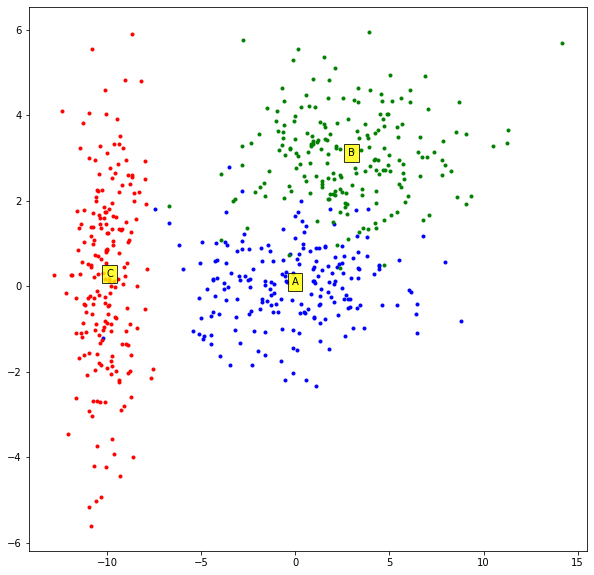

In [4]:
plt.figure(figsize=(10, 10))
colors = ('blue','green','red')
titles = ["A", "B", "C"]
for title, class_points, color in zip(titles, [a_xy, b_xy, c_xy], colors):
    plt.plot(class_points[0], class_points[1], ".", color=color)
    plt.text(x=np.mean(class_points[0]), y = np.mean(class_points[1]), s=title, bbox=dict(facecolor='yellow', alpha=0.8))

Looking at plots we can suppose that data of each class is from Gaussian distribution. Class A and B are likely to have covariance matrix close to isotropic one. Let's try to estimate parameters of this distributions.

In [5]:
titles = ["A", "B", "C"]
class_mean = []
class_cov = []

for title, class_points in zip(titles, [a, b, c]):
    class_mean.append(np.mean(class_points, axis=0))
    class_cov.append(np.cov(class_points.T))
    print(f"Class {title}:\n Mean: {class_mean[-1]},\n Covariance matrix:\n {class_cov[-1]}")

Class A:
 Mean: [-0.21000115  0.03048009],
 Covariance matrix:
 [[10.02769733  0.13162336]
 [ 0.13162336  0.83932673]]
Class B:
 Mean: [2.8018991 3.0535643],
 Covariance matrix:
 [[10.17034812  0.18023771]
 [ 0.18023771  1.0840038 ]]
Class C:
 Mean: [-10.05748461   0.22582978],
 Covariance matrix:
 [[0.97013029 0.23458112]
 [0.23458112 4.69756273]]


Using obtained parameters of distributions let's define discrimant function for each class.

In [6]:
def discriminant_func(x, mean, cov):
    return -1/2 * np.matmul(np.matmul((x - mean), np.linalg.inv(cov)), (x - mean)) + \
            np.log(1/np.sqrt((2 * np.pi)**(len(x))) / np.sqrt(np.linalg.det(cov)))

Comparing values of discriminant function we can assign class to new points

In [7]:
def predict_gaussian(x, class_mean, class_cov, labels):
    discriminant_values = [discriminant_func(x, mean, cov) for (mean, cov) in zip(class_mean, class_cov)]
    return labels[np.argmax(discriminant_values)]

Now, let's draw decision boundaries of obtained model

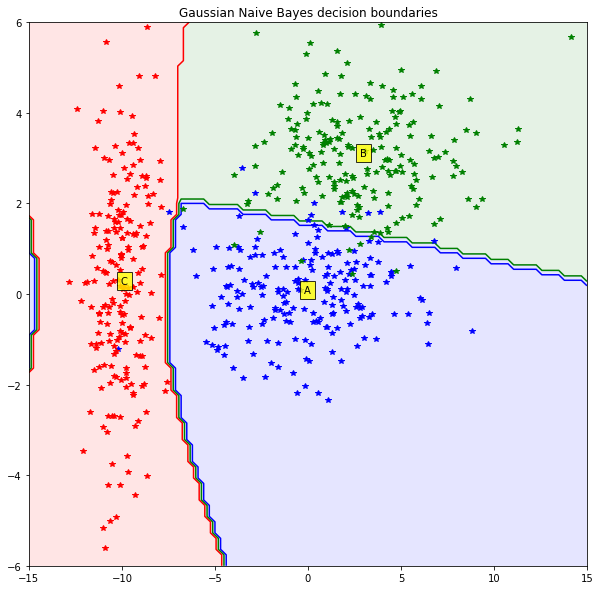

In [8]:
N = 100
X = np.linspace(-15, 15, N)
Y = np.linspace(-6, 6, N)
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize = (10,10))
ax = fig.gca()

predictions = np.array([predict_gaussian(x, class_mean, class_cov, [0, 1, 2])
                        for x in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

#Plot the filled and boundary contours
ax.contourf(X, Y, predictions, 2, alpha = .1, colors=colors)
ax.contour(X, Y, predictions, 2, alpha = 1, colors=colors)

# Add axis and title
ax.set_title('Gaussian Naive Bayes decision boundaries')
for title, class_points, color in zip(titles, [a_xy, b_xy, c_xy], colors):
    ax.plot(class_points[0], class_points[1], "*", color=color)
    ax.text(x=np.mean(class_points[0]), y = np.mean(class_points[1]), s=title, bbox=dict(facecolor='yellow', alpha=0.8))

Let's get some numerical value which will represent quality of obtained model.

In [9]:
data = np.vstack((a, b, c))
labels = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))

predicted =  np.array([predict_gaussian(el, class_mean, class_cov, [0, 1, 2]) for el in data])
accuracy = (predicted == labels).sum() / len(data)
print(f"Obtained model accuracy on train data is {accuracy * 100}%")

Obtained model accuracy on train data is 96.5%


---

#### 1.1.2 Going beyond

Now just for curiosity reasons let's see how our model differ for sklearn' one. 

In [10]:
from sklearn.naive_bayes import GaussianNB

We will use [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) which will estimate parameters of distributions and on that basis creat model for future predictions.

In [11]:
model_gaussian = GaussianNB(priors = None)
model_gaussian.fit(data, labels)

GaussianNB(priors=None, var_smoothing=1e-09)

Let's plot decision trees of fitted model to see whether it worked.

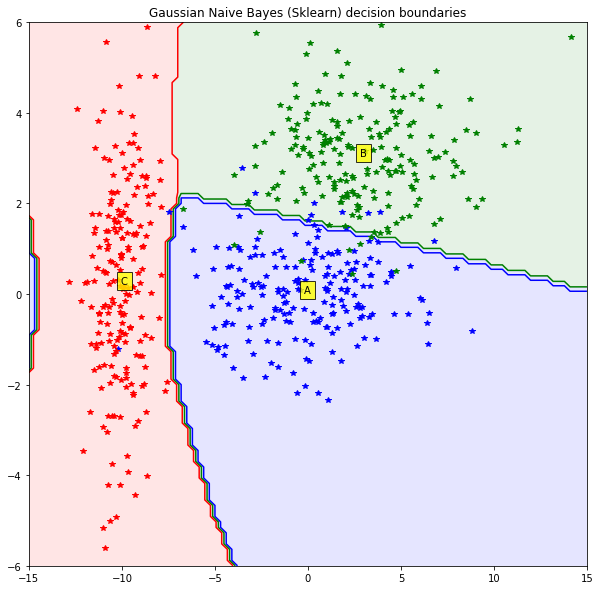

In [12]:
N = 100
X = np.linspace(-15, 15, N)
Y = np.linspace(-6, 6, N)
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize = (10,10))
ax = fig.gca()

predictions_sklearn = np.array([model_gaussian.predict([[xx,yy]])[0]
                                for xx, yy in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

#Plot the filled and boundary contours
ax.contourf(X, Y, predictions_sklearn, 2, alpha = .1, colors=colors)
ax.contour(X, Y, predictions_sklearn, 2, alpha = 1, colors=colors)

# Add axis and title
ax.set_title('Gaussian Naive Bayes (Sklearn) decision boundaries')
for title, class_points, color in zip(titles, [a_xy, b_xy, c_xy], colors):
    ax.plot(class_points[0], class_points[1], "*", color=color)
    ax.text(x=np.mean(class_points[0]), y = np.mean(class_points[1]), s=title, bbox=dict(facecolor='yellow', alpha=0.8))

We see that class's regions looks like obtained above with our method. Let's estimate difference etween them.  

In [13]:
values, counts = np.unique(predictions == predictions_sklearn, return_counts=True)
print(f"Our method differed from sklearn's in{counts[np.where(values==False)][0] / N**2 * 100: 0.2f} % of points on grid") 

Our method differed from sklearn's in 1.14 % of points on grid


In [14]:
predicted =  np.array([model_gaussian.predict([el])[0] for el in data])
accuracy = (predicted == labels).sum() / len(data)
print(f"Obtained model accuracy on train data is {accuracy * 100}%")

Obtained model accuracy on train data is 96.5%


Great, our model has the same accuracy as model from sklearn!

---

### 1.2 Mahalanobis distance
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

To use Mahalanobis distance we need to assume that classes A and B have the same covariance matrix. Let's first take a look at them.

In [15]:
for title, cov in zip(titles, class_cov[:2]):
    print(f"Class {title}:\n Covariance matrix:\n {cov}")

Class A:
 Covariance matrix:
 [[10.02769733  0.13162336]
 [ 0.13162336  0.83932673]]
Class B:
 Covariance matrix:
 [[10.17034812  0.18023771]
 [ 0.18023771  1.0840038 ]]


To evaluate their similarity we will use Frobenius distance.

In [16]:
print(f"Frobenius distance is{np.linalg.norm(class_cov[0] - class_cov[1], ord='fro'): 0.5f}")

Frobenius distance is 0.29145


It looks like matrices are close to be similar. Thus we can use Mahalanobis distance and the most probable class will be the one which will minimize it.

In [17]:
def mahalanobis_dist(x, mean, cov):
    return np.sqrt(np.matmul(np.matmul((x - mean), np.linalg.inv(cov)), (x - mean)))

In [18]:
def predict_mahalanobis(x, class_mean, cov, labels):
    discriminant_values = [discriminant_func(x, mean, cov) for mean in class_mean]
    return labels[np.argmax(discriminant_values)]

In [19]:
class_mean_2classes = class_mean[:2] # Take only values for class A and B
class_cov_2classes = class_cov[:2] # Take only values for class A and B
cov = class_cov[0] # Assume that covariance matrices are the same

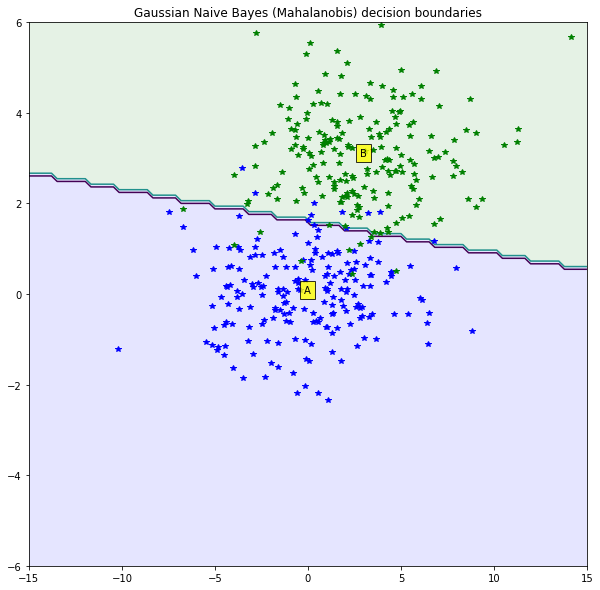

In [20]:
N = 100
X = np.linspace(-15, 15, N)
Y = np.linspace(-6, 6, N)
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize = (10,10))
ax = fig.gca()

predictions_mahalanobis = np.array([predict_mahalanobis(x, class_mean_2classes, cov, [0, 1])
                                    for x in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

#Plot the filled and boundary contours
ax.contourf(X, Y, predictions_mahalanobis, 1, alpha = .1, colors=colors)
ax.contour(X, Y, predictions_mahalanobis, 1, alpha = 1)

# Add axis and title
ax.set_title('Gaussian Naive Bayes (Mahalanobis) decision boundaries')
for title, class_points, color in zip(titles, [a_xy, b_xy], colors):
    ax.plot(class_points[0], class_points[1], "*", color=color)
    ax.text(x=np.mean(class_points[0]), y = np.mean(class_points[1]), s=title, bbox=dict(facecolor='yellow', alpha=0.8))

Let's compare this model to "complete" Naive Bayes

In [21]:
predictions_mahalanobis = np.array([predict_mahalanobis(x, class_mean_2classes, cov, [0, 1])
                                    for x in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)
predictions_gaussian = np.array([predict_gaussian(x, class_mean_2classes, class_cov_2classes, [0, 1])
                                    for x in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

We will plot regions where predictions are not the same for models.

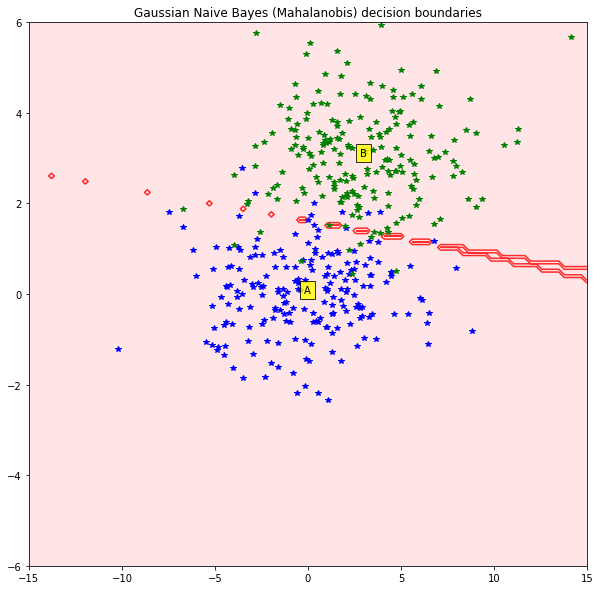

In [22]:
N = 100
X = np.linspace(-15, 15, N)
Y = np.linspace(-6, 6, N)
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize = (10,10))
ax = fig.gca()


are_different = predictions_gaussian == predictions_mahalanobis

#Plot the filled and boundary contours
ax.contour(X, Y, are_different, 1, alpha = 0.8, colors=["red"])
ax.contourf(X, Y, are_different, 1, alpha = .1, colors=["red"])

# Add axis and title
ax.set_title('Gaussian Naive Bayes (Mahalanobis) decision boundaries')
for title, class_points, color in zip(titles, [a_xy, b_xy], colors):
    ax.plot(class_points[0], class_points[1], "*", color=color)
    ax.text(x=np.mean(class_points[0]), y = np.mean(class_points[1]), s=title, bbox=dict(facecolor='yellow', alpha=0.8))

On plot above red regions denote space where models predict not the same classes. As we can see such regions are located on the border between two classes. These regions are relatively small which leads us to an conclusion that there is not too much difference between obtaioned models.

Again, let's represent models' quallity as numerical value and compare them.

In [23]:
data_2classes = np.vstack((a, b))
labels_2classes = np.array([0] * len(a) + [1] * len(b))

predicted_mahalanobis =  np.array([predict_mahalanobis(el, class_mean_2classes, cov, [0, 1]) for el in data_2classes])
accuracy_mahalanobis = (predicted_mahalanobis == labels_2classes).sum() / len(data_2classes)

predicted_gaussian =  np.array([predict_gaussian(el, class_mean_2classes, class_cov_2classes, [0, 1]) for el in data_2classes])
accuracy_gaussian = (predicted_gaussian == labels_2classes).sum() / len(data_2classes)

print(f"Mahalonobis model accuracy on train data with 2 classes is {accuracy_mahalanobis * 100}%")
print(f"Gaussian model accuracy on train data with 2 classes is {accuracy_gaussian * 100}%")

Mahalonobis model accuracy on train data with 2 classes is 94.75%
Gaussian model accuracy on train data with 2 classes is 95.25%


Here we see, that by making assumation that both classes have same covarience matrix makes our model a bit simpler and a bit less accurate in predictions.

---

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python.

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [24]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [25]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

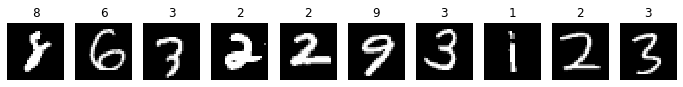

In [26]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP

For this task we will use a very popular library for AI - [PyTorch](https://pytorch.org). First let us create a NN module using typical PyTorch pipeline.

In [27]:
import torch
from torch import nn
from torch.nn import functional as F

# Creating a Net class object, which consists of 2 perceptron layers
class MLP_Net(nn.Module):
    
    # The object initialization
    def __init__(self, nb_hidden = 100):        
        super(MLP_Net, self).__init__()
        self.fc1 = nn.Linear(784, nb_hidden)  # the input linear layer, which get raw pixel values
        self.fc2 = nn.Linear(nb_hidden, 10)  # the output linear layer, which outputs probs for all digits
    
    # Creating the forward pass
    def forward(self, x):
        
        # First perceptron layer
        x = F.relu(self.fc1(x))
        
        # Second perceptron layer
        x = self.fc2(x)
        
        return x

Now let us implement two auxiliary functions: `train_model()` is used to train the model, while `compute_nb_errors()` is used to compute the number of wrong classification on an input tensor.

All the activations in the MLP will be done through [ReLU](https://pytorch.org/docs/stable/nn.html#torch.nn.ReLU).

For the training we will use [CrossEntropy](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss) criterion which is a standard loss for multi-class classification task. Also we will use [Adam](https://arxiv.org/abs/1412.6980) algorithm which is an improved version of SGD. We will train the model by dividing the data set into small batches if size 100, which is a standard procedure.

In [28]:
def train_model(model, train_inputs, train_targets, mini_batch_size=100, remember_losses=True, lr=1e-3, nb_epochs=20):
    
    """
        Train the PyTorch model on the training set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model      
        train_inputs : torch.Tensor object
            The input train feature set
        train_targets : torch.Tensor object
            The input train label set
        mini_batch_size : int
            The size of the batch processing size
        remember_losses : boolean
            True if remember losses for model evaluation, False if not
            
        Returns
        -------
        
        NN object or (NN object, list)
            If remember_losses is True then the function returns both
            the trained model and the list of losses for each epoch. 
            If remember_losses is False then the function return only
            the trained model.
    """
    
    # Defining the learning rate and number of epochs
    losses = []

    # Defining the optimizer for GD
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) 
    
    # Defining the criterion to calculate loss
    criterion = nn.CrossEntropyLoss()
    
    # Learning loop
    for e in range(nb_epochs):
        # Train the input dataset by dividing it into mini_batch_size small datasets
        for train_input, train_target in zip(train_inputs.split(mini_batch_size), train_targets.split(mini_batch_size)):
            output = model(train_input)
            loss = criterion(output, train_target) 
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
        losses.append(loss)
        print('%dth epoch is finished and the loss is %f' % (e+1, loss))
           
    
    return model, losses
        
def compute_nb_errors(model, data_inputs, targets, mini_batch_size=100):
    
    """
        Compute the number of errors the model infers on the data set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model      
        tensor_inputs : torch.Tensor object
            The input feature set
        targets : torch.Tensor object
            The input label set
        mini_batch_size : int
            The size of the batch processing size
            
        Returns
        -------
        int
            The number of errors the model infers
    """
    
    nb_errors = 0
    
    # Processing the data set by mini batches
    for data_input, target in zip(data_inputs.split(mini_batch_size), targets.split(mini_batch_size)):
        output = model(data_input)
        _, predicted_classes = output.max(1)
        nb_errors += (target != predicted_classes).sum().item()
                
    return nb_errors

Now we are ready to train our model! Before passing our training sets into `train_model()` function we will normalize them, which is also a standard procedure that could improve the results.

In [29]:
%%time

# Creating PyTorch tensors from training and test sets
train_inputs, test_inputs = torch.Tensor(train_images).view(-1, 784), torch.Tensor(test_images).view(-1, 784)
train_targets, test_targets = torch.Tensor(train_labels).long(), torch.Tensor(test_labels).long()

# Normalize the training sets
mu, std = train_inputs.mean(), train_inputs.std() 
train_inputs.sub_(mu).div_(std)

# Normalize the test sets
test_inputs.sub_(mu).div_(std)

# Create a MLP object
MLP = MLP_Net()

# Train the model
nb_epochs = 20
MLP, losses = train_model(MLP, train_inputs, train_targets, nb_epochs=nb_epochs)

1th epoch is finished and the loss is 0.258676
2th epoch is finished and the loss is 0.224071
3th epoch is finished and the loss is 0.192575
4th epoch is finished and the loss is 0.183516
5th epoch is finished and the loss is 0.165018
6th epoch is finished and the loss is 0.137636
7th epoch is finished and the loss is 0.117634
8th epoch is finished and the loss is 0.105153
9th epoch is finished and the loss is 0.104470
10th epoch is finished and the loss is 0.103550
11th epoch is finished and the loss is 0.072616
12th epoch is finished and the loss is 0.046329
13th epoch is finished and the loss is 0.065031
14th epoch is finished and the loss is 0.053783
15th epoch is finished and the loss is 0.026010
16th epoch is finished and the loss is 0.030880
17th epoch is finished and the loss is 0.031249
18th epoch is finished and the loss is 0.001913
19th epoch is finished and the loss is 0.009031
20th epoch is finished and the loss is 0.000755
CPU times: user 1min 59s, sys: 5.42 s, total: 2mi

So now let us evaluate the model perfomance.

In [30]:
# Calculate the number of errors on the training set and on the test set.
nb_errors_train = compute_nb_errors(MLP, train_inputs, train_targets)
nb_errors_test = compute_nb_errors(MLP, test_inputs, test_targets)

mlp_accuracy_train = (train_inputs.size(0) - nb_errors_train) / train_inputs.size(0)
mlp_accuracy_test = (test_inputs.size(0) - nb_errors_test) / test_inputs.size(0)
print(f"Accuracy train: {mlp_accuracy_train:0.4f}, test: {mlp_accuracy_test:0.4f}")

Accuracy train: 0.9946, test: 0.9759


The MLP works great!

Let us now plot the the training loss vs epoch plot.

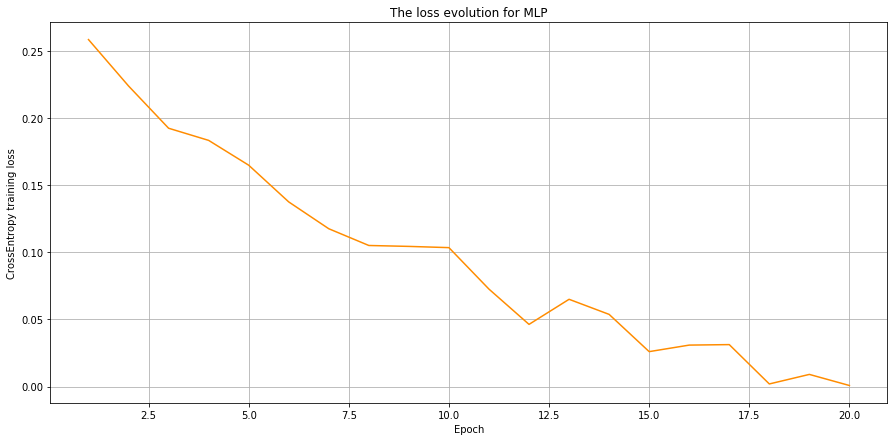

In [31]:
# Creating an array with nb_epoch values
epochs = np.arange(1, nb_epochs+1)

# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(epochs, losses, 'darkorange')
ax.set_ylabel('CrossEntropy training loss')
ax.set_xlabel('Epoch')
ax.grid(True)
ax.set_title('The loss evolution for MLP');

We can conclude that we reached convergence already on the 16-17 training epoch.

Now let us check how well MLP classifies different digits.

In [32]:
def get_subset_with_digit(data_inputs, targets, digit):
    
    """
        Get the subset with one digit labels from the data set.
        
        Parameters
        ----------     
        data_inputs : torch.Tensor object
            The input feature set
        targtargetsets : torch.Tensor object
            The input label set
        digit : int
            The digit you want to extract from data set
            
        Returns
        -------
        (torch.Tensor, torch.Tensor)
            The subset (images and labels)of the initial dataset with only one digit
    """
    
    digit_inputs = data_inputs[targets == digit]
    digit_targets = targets[targets == digit]
    
    return digit_inputs, digit_targets

In [33]:
for digit in range(10):
    
    # Get digit-specific subsets
    digit_train_inputs, digit_train_targets = get_subset_with_digit(train_inputs, train_targets, digit)
    digit_test_inputs, digit_test_targets = get_subset_with_digit(test_inputs, test_targets, digit)
    
    # Calculate the number of errors on the training set and on the test set.
    nb_errors_train = compute_nb_errors(MLP, digit_train_inputs, digit_train_targets)
    nb_errors_test = compute_nb_errors(MLP, digit_test_inputs, digit_test_targets)
    
    train_accuracy = (train_inputs.size(0) - nb_errors_train)/train_inputs.size(0)
    test_accuracy = (test_inputs.size(0) - nb_errors_test)/test_inputs.size(0)
    
    print('Train accuracy of %d: %f, Test accuracy of %d: %f' % (digit, train_accuracy, digit, test_accuracy))

Train accuracy of 0: 1.000000, Test accuracy of 0: 0.999400
Train accuracy of 1: 0.999500, Test accuracy of 1: 0.998900
Train accuracy of 2: 0.999783, Test accuracy of 2: 0.997800
Train accuracy of 3: 0.999417, Test accuracy of 3: 0.998100
Train accuracy of 4: 0.999833, Test accuracy of 4: 0.997400
Train accuracy of 5: 0.999967, Test accuracy of 5: 0.998700
Train accuracy of 6: 0.999133, Test accuracy of 6: 0.997500
Train accuracy of 7: 0.998733, Test accuracy of 7: 0.995000
Train accuracy of 8: 0.998583, Test accuracy of 8: 0.995300
Train accuracy of 9: 0.999617, Test accuracy of 9: 0.997800


Works great!

### 2.2 Convolutional neural network

We thought it would be interesting to compare the perfomance of multi-layer perceptron to the typical convolution neural network which are usually used for tasks related to iamge classification. To do that let us create a `Conv_Net` class.

Our convolutional neural network will have next layers:
- Convolutional layer with 1 input channel, 16 output channels and 3x3 size kernel
- Max pooling with 2x2 size kernel
- Convolutional layer with 16 input channels, 32 output channels and 3x3 size kernel
- Max pooling with 2x2 size kernel
- Pseudo-layer which flattens the input data for the following fully-connected layer
- Fully-connected layer with 800 input units and `nb_hidden = 100` output units, followed by ReLU
- Fully-connected layer with `nb_hidden = 100` input units and 10 output units, which are the model output

So in our convolutional neural network the last 2 layers are preserved from MLP built before.

In [34]:
# Creating a Net class object, which consists of 2 convolutional layers, max-pool layers and fully-connected layers
class Conv_Net(nn.Module):
    def __init__(self, nb_hidden=100):        
        super(Conv_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)  # the first convolutional layer, which processes the input image
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)  # the second convolutional layer, which gets the max-pooled set
        self.fc1 = nn.Linear(800, nb_hidden)  # the first fully-connected layer, which gets flattened max-pooled set
        self.fc2 = nn.Linear(nb_hidden, 10)  # the second fully-connected layer that outputs the result

    # Creating the forward pass
    def forward(self, x):
        
        # The first two layers
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        
        # The second two layers
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2)) 
        
        # Flattening the data set for fully-connected layer
        x = x.view(x.size(0), -1)
    
        # The first fully-connected layer
        x = F.relu(self.fc1(x))
        
        # The second full-connected layer
        x = self.fc2(x)
        
        return x

For convolutional network the input data will be different - we should pass the raw images to the model (2D - 28x28), not the flattened one (1D - 784). Moreover, the PyTorch convolutional layer module takes multi-channel images as default, so we should add one more dimension to the tensor, which will indicate the channel of the image (in MNIST dataset we have 1-channel images). We could use the same functions implemented before to train the model and to compute the number of wrong classifications.

In [35]:
%%time
### WARNING
###
### It will take a while to finish running this cell
###
###

# Creating PyTorch tensors from training and test sets
train_inputs_conv, test_inputs_conv = torch.Tensor(train_images).view(-1, 1, 28, 28), \
    torch.Tensor(test_images).view(-1, 1, 28, 28)
train_targets, test_targets = torch.Tensor(train_labels).long(), torch.Tensor(test_labels).long()

# Normalize the training sets
mu, std = train_inputs_conv.mean(), train_inputs_conv.std() 
train_inputs_conv.sub_(mu).div_(std)

# Normalize the test sets
test_inputs_conv.sub_(mu).div_(std)

# Create a Conv_Net object
conv_net = Conv_Net()

# Train the model
nb_epochs = 5
conv_net, losses = train_model(conv_net, train_inputs_conv, train_targets, nb_epochs=nb_epochs)

1th epoch is finished and the loss is 0.207029
2th epoch is finished and the loss is 0.195231
3th epoch is finished and the loss is 0.195360
4th epoch is finished and the loss is 0.198382
5th epoch is finished and the loss is 0.191187
CPU times: user 11min 25s, sys: 34 s, total: 11min 59s
Wall time: 1min 52s


Now let us evaluate the model the same way we did before.

In [36]:
# Calculate the number of errors on the training set and on the test set.
nb_errors_train = compute_nb_errors(conv_net, train_inputs_conv, train_targets)
nb_errors_test = compute_nb_errors(conv_net, test_inputs_conv, test_targets)

conv_accuracy_train = (train_inputs_conv.size(0) - nb_errors_train) / train_inputs_conv.size(0)
conv_accuracy_test = (test_inputs_conv.size(0) - nb_errors_test) / test_inputs_conv.size(0)
print(f"Accuracy train: {conv_accuracy_train:0.4f}, test: {conv_accuracy_test:0.4f}")

Accuracy train: 0.9926, test: 0.9874


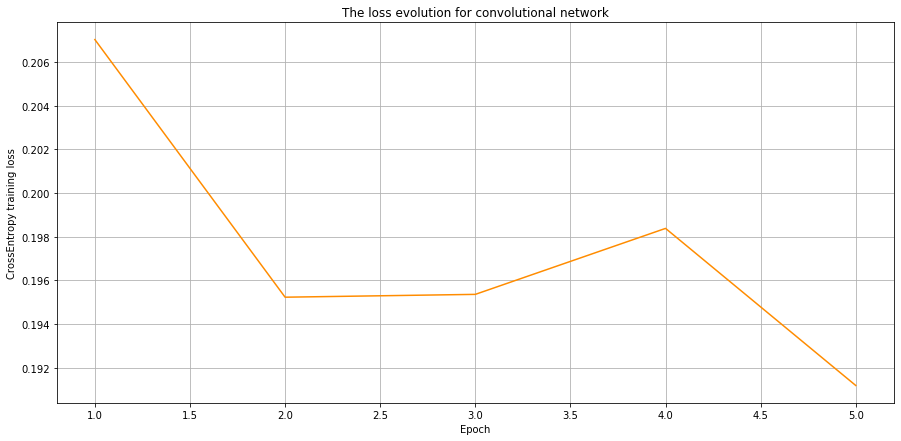

In [37]:
# Creating an array with nb_epoch values
epochs = np.arange(1, nb_epochs+1)

# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(epochs, losses, 'darkorange')
ax.set_ylabel('CrossEntropy training loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for convolutional network');

In [38]:
for digit in range(10):
    
    # Get digit-specific subsets
    digit_train_inputs, digit_train_targets = get_subset_with_digit(train_inputs_conv, train_targets, digit)
    digit_test_inputs, digit_test_targets = get_subset_with_digit(test_inputs_conv, test_targets, digit)
    
    # Calculate the number of errors on the training set and on the test set.
    nb_errors_train = compute_nb_errors(conv_net, digit_train_inputs, digit_train_targets)
    nb_errors_test = compute_nb_errors(conv_net, digit_test_inputs, digit_test_targets)
    
    train_accuracy = (train_inputs.size(0) - nb_errors_train)/train_inputs.size(0)
    test_accuracy = (test_inputs.size(0) - nb_errors_test)/test_inputs.size(0)
    
    print('Train accuracy of %d: %f, Test accuracy of %d: %f' % (digit, train_accuracy, digit, test_accuracy))

Train accuracy of 0: 0.999800, Test accuracy of 0: 0.999400
Train accuracy of 1: 0.999683, Test accuracy of 1: 0.999500
Train accuracy of 2: 0.999633, Test accuracy of 2: 0.999200
Train accuracy of 3: 0.999633, Test accuracy of 3: 0.999300
Train accuracy of 4: 0.997700, Test accuracy of 4: 0.997600
Train accuracy of 5: 0.999250, Test accuracy of 5: 0.998900
Train accuracy of 6: 0.999167, Test accuracy of 6: 0.997900
Train accuracy of 7: 0.999000, Test accuracy of 7: 0.998300
Train accuracy of 8: 0.999383, Test accuracy of 8: 0.998900
Train accuracy of 9: 0.999317, Test accuracy of 9: 0.998400


#### Conclusion

In [39]:
mlp_nb_params = sum(p.numel() for p in MLP.parameters() if p.requires_grad)
conv_nb_params = sum(p.numel() for p in conv_net.parameters() if p.requires_grad)

In [40]:
data = [["MLP", mlp_accuracy_train, mlp_accuracy_test, mlp_nb_params],
        ["CNN", conv_accuracy_train, conv_accuracy_test, conv_nb_params]]
models_info = pd.DataFrame(data, columns=["Model", "Accuracy on train set", "Accuracy on test set", "Number of model's parameters"])

In [41]:
print(models_info.to_string(index=False))

Model  Accuracy on train set  Accuracy on test set  Number of model's parameters
  MLP               0.994567                0.9759                         79510
  CNN               0.992567                0.9874                         85910


In the ouput of the cell above one can observe the final evaluation of MLP and CNN models. We could conclude that both of these models work almost perfectly on the MNIST dataset. We should mention that CNN is more complicated model MLP as it has higher number of parameters, although it infers better results.